**REFERENCE MATERIALS**

1]https://itk.org/ITKSoftwareGuide/html/

2] http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html#Utility-functions

3]https://simpleitk.readthedocs.io/en/master/registrationOverview.html

4]https://simpleitk.org/SPIE2019_COURSE/04_basic_registration.html

5]http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/62_Registration_Tuning.html

6]http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/63_Registration_Initialization.html



**IMPORT NECESSARY LIBRARIES**

In [2]:
import ITK
import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

**DEFINE UTILITY FUNCTIONS**

In [3]:
# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

**LOAD DATA**

In [4]:
fixed_image =  sitk.ReadImage(("C:/Users/PC/Desktop/SEM-7-ACA/registration_ass/VF-MRT1-1014-1174.vtk"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(("C:/Users/PC/Desktop/SEM-7-ACA/registration_ass/VF-MRT2-1014-1174.vtk"), sitk.sitkFloat32) 

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=16, description='fixed_image_z', max=32), IntSlider(value=31, descriptio…

**ALIGN THE CENTERS OF THE TWO VOLUMES aAND SET THE CENTER OF ROTATION TO THE CENTER OF THE FIXED IMAGE**

In [5]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkGaussian, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=16, description='image_z', max=32), FloatSlider(value=0.5, description='…

**REGISTRATION**

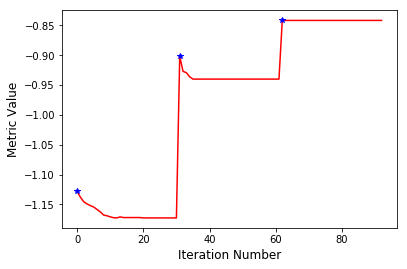

In [6]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkGaussian)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
 
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

**METRIC VALUE**

In [7]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.8417733751264067
Optimizer's stopping condition, GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 31.


**FINAL TRANSFORM**

In [12]:
print(final_transform)

itk::simple::Transform
 CompositeTransform (000000CB870289E0)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 71120
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (000000CB8672C7D0)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 71112
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999996 -0.00216746 0.00175189 
       0.00218584 0.999942 -0.0105589 
       -0.0017289 0.0105627 0.999943 
     Offset: [0.116877, -7.69316, -1.80574]
     Center: [101.654, 111.555, 87.4898]
     Translation: [0.0279629, -8.40124, -0.808181]
     Inverse: 
       0.999996 0.00218584 -0.0017289 
       -0.00216746 0.999942 0.0105627 
       0.00175189 -0.0105589 0.999943 
     Singular: 0
     Euler's angles: AngleX=0.0105629 AngleY=0.001729 AngleZ=0.00216759
     m_ComputeZYX = 0

**VISUALISE THE RESULTS**

In [9]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkNearestNeighbor, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=16, description='image_z', max=32), FloatSlider(value=0.5, description='…

**SAVE TO LOCAL WORKSTATION**

In [10]:
OUTPUT_DIR = 'C:/Users/PC/Desktop/SEM-7-ACA/registration_ass/'

In [11]:
import os

In [14]:
sitk.WriteImage(moving_resampled, os.path.join(OUTPUT_DIR, '24_moving_image.mha'))
sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'RIRE_training_001_CT_2_mr_T1.tfm'))

In [15]:
sitk.WriteImage(fixed_image, os.path.join(OUTPUT_DIR, '24_fixed_image.mha'))